# Question 1:

Reqired Model details as given in the question:

In [1]:
# ABC = 087
# DD = 07,      MM = 08,      YY = 02
# MNIST dataset
# Weight initialization = Xavier initialization
# Data Augmentation = rotate by 10 degrees and gaussian noise.
# Pooling = AvgPool
# Targets = 1,3,5,7,9
# Feature Extraction Layers = 5 conv layers and 1 pooling layer,    8 filters in 1st layer
# 1 FC layer with 256 nodes

print("FIRST: ", "Adarsh" )
print("LAST: ", "Palaskar" )

FIRST:  Adarsh
LAST:  Palaskar


In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 

import torchvision
from torch.utils.data import DataLoader 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score, roc_curve


In [3]:
# Rotate the images by 10 degrees
class Rotation(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, x):
        return transforms.functional.rotate(x, self.degrees)

# Add Gaussian noise to the images
class AddGaussianNoise(object):
    def __call__(self, x):
        gaussian_noise = 0.3*np.random.normal(0.5, 0.5, size=x.shape)
        x = x + gaussian_noise
        return x

class ClipDataset(object):
    def __call__(self,x):
        return np.clip(x,0,1)

data_augmentations = [
    Rotation(10),
    AddGaussianNoise() ]


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomApply(data_augmentations,p=0.5),       # Randomly apply any 1 augmentation with a probabilty of 0.5 
    ClipDataset()
])


In [4]:
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transform, download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Filter the data to only keep classes 1, 3, 5, 7, and 9

In [5]:
req_targets = torch.tensor([1, 3, 5, 7, 9])

train_dataset.data = train_dataset.data[torch.isin(train_dataset.targets, req_targets)]
train_dataset.targets = train_dataset.targets[torch.isin(train_dataset.targets, req_targets)]

test_dataset.data = test_dataset.data[torch.isin(test_dataset.targets, req_targets)]
test_dataset.targets = test_dataset.targets[torch.isin(test_dataset.targets, req_targets)]

Re-label the dataset as 1->0, 3->1, 5->2, 7->3, ->4

In [6]:
train_dataset.targets = (train_dataset.targets - 1) // 2
test_dataset.targets = (test_dataset.targets - 1) // 2

In [7]:
train_dataset.targets

tensor([2, 0, 4,  ..., 0, 1, 2])

Perform PCA to visualize the dataset:

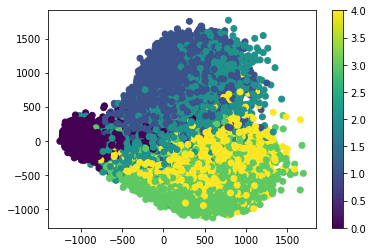

In [8]:

pca = PCA(n_components=2)
X = train_dataset.data
X = X.numpy()
X = X.reshape(X.shape[0], -1)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_dataset.targets, cmap='viridis')
plt.colorbar()
plt.show()

Creating a Validation Split

In [9]:

torch.manual_seed(43)
val_size = 6000
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(24508, 6000)

In [10]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

Show the Augmented Images:

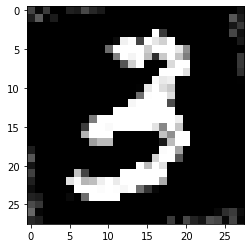

torch.Size([256, 1, 28, 28])
tensor(1)


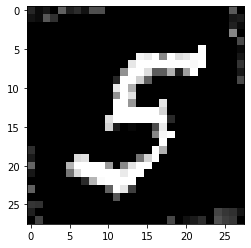

torch.Size([256, 1, 28, 28])
tensor(2)


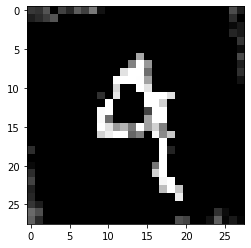

torch.Size([256, 1, 28, 28])
tensor(4)


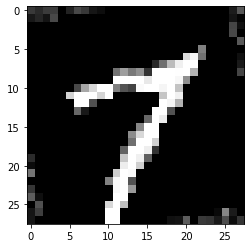

torch.Size([256, 1, 28, 28])
tensor(3)


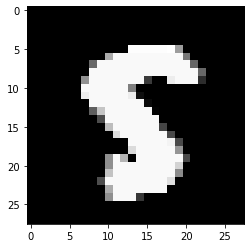

torch.Size([256, 1, 28, 28])
tensor(2)


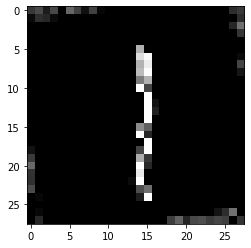

torch.Size([256, 1, 28, 28])
tensor(0)


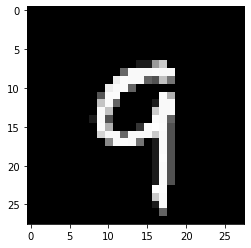

torch.Size([256, 1, 28, 28])
tensor(4)


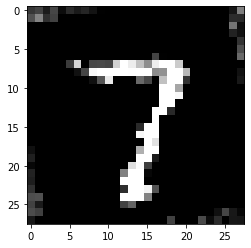

torch.Size([256, 1, 28, 28])
tensor(3)


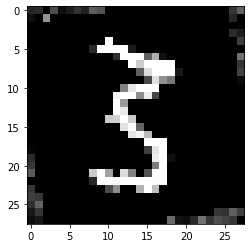

torch.Size([256, 1, 28, 28])
tensor(1)


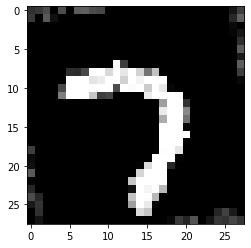

torch.Size([256, 1, 28, 28])
tensor(3)


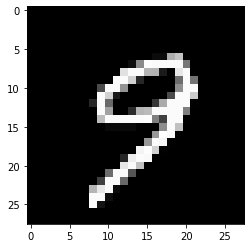

torch.Size([256, 1, 28, 28])
tensor(4)


In [11]:
def imshow(img):

  npimg = img.numpy()   # convert from tensor to numpy
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

for batch_idx, (data, targets) in enumerate(train_loader):
    if(batch_idx >10): break
    imshow(torchvision.utils.make_grid(data[3]))
    print(data.shape)
    print(targets[3])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define the Convolutional Neural Network

In [13]:

import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(64, 256, 3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features=256, out_features=5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [14]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Initialize the weights using Xavier initialization

In [15]:

for m in model.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)


In [16]:
train_losses=[]
train_accu=[]

eval_losses=[]
eval_accu=[]

y_true = []
y_pred = []
y_scores = []


def test(data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0

        for images, labels in data_loader:

            images = images.to(device=device)
            labels = labels.to(device=device)

            images = images.float()
            outputs = model(images)

            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            y_scores.extend(F.softmax(outputs, dim=1).tolist())
        
        test_loss=running_loss/len(data_loader)
        accu=100.*correct/total

        eval_losses.append(test_loss)
        eval_accu.append(accu)

        if(data_loader == test_loader):
            print(f'Accuracy of the model on the test data: {accu}%')
        else:
            print('Validation Loss: %.3f | Validation Accuracy: %.3f'%(test_loss,accu))



Testing the CNN

In [17]:

no_of_epochs = 30

for epoch in range(no_of_epochs):
    running_loss = 0.0
    correct=0
    total=0
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device=device)
        labels = labels.to(device=device)

        optimizer.zero_grad()

        images = images.float()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)

    print(f'Epoch [{epoch + 1}/{no_of_epochs}]' + ' | '+'Train Loss: %.3f | Train Accuracy: %.3f'%(train_loss,accu), end =' | ')
    test(val_loader)

print('Finished Training')


Epoch [1/30] | Train Loss: 1.113 | Train Accuracy: 50.253 | Validation Loss: 0.797 | Validation Accuracy: 64.933
Epoch [2/30] | Train Loss: 0.766 | Train Accuracy: 69.271 | Validation Loss: 0.673 | Validation Accuracy: 73.683
Epoch [3/30] | Train Loss: 0.612 | Train Accuracy: 78.958 | Validation Loss: 0.514 | Validation Accuracy: 82.933
Epoch [4/30] | Train Loss: 0.476 | Train Accuracy: 85.001 | Validation Loss: 0.452 | Validation Accuracy: 84.283
Epoch [5/30] | Train Loss: 0.390 | Train Accuracy: 88.269 | Validation Loss: 0.340 | Validation Accuracy: 89.983
Epoch [6/30] | Train Loss: 0.317 | Train Accuracy: 90.823 | Validation Loss: 0.279 | Validation Accuracy: 91.350
Epoch [7/30] | Train Loss: 0.277 | Train Accuracy: 91.852 | Validation Loss: 0.274 | Validation Accuracy: 91.467
Epoch [8/30] | Train Loss: 0.246 | Train Accuracy: 92.892 | Validation Loss: 0.214 | Validation Accuracy: 93.667
Epoch [9/30] | Train Loss: 0.214 | Train Accuracy: 93.716 | Validation Loss: 0.187 | Validation 

In [18]:
test(test_loader)

Accuracy of the model on the test data: 97.79266850610958%


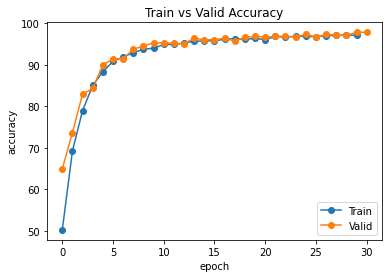

In [19]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

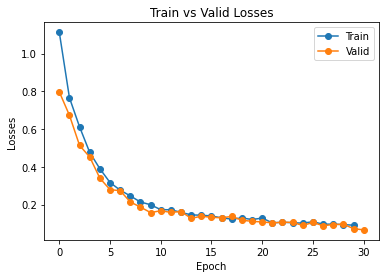

In [20]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')

plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score, roc_curve

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[39703    56   106   189   171]
 [   49 34652   976   662   941]
 [  203  2161 29447   577   604]
 [  521   699   604 35578  1126]
 [  597   562   738  1088 33064]]


Confusion Matrix:

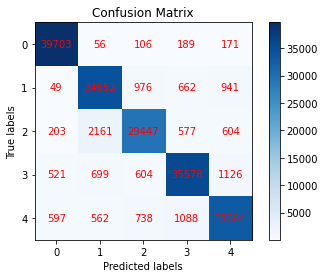

In [22]:
# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(np.arange(5))
plt.yticks(np.arange(5))
plt.title('Confusion Matrix')
plt.colorbar()

for i in range(5):
    for j in range(5):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.show()

In [23]:
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     40225
           1       0.91      0.93      0.92     37280
           2       0.92      0.89      0.91     32992
           3       0.93      0.92      0.93     38528
           4       0.92      0.92      0.92     36049

    accuracy                           0.93    185074
   macro avg       0.93      0.93      0.93    185074
weighted avg       0.93      0.93      0.93    185074



# Question 2

Required Model details:

In [24]:
# Number of AutoEncoder layer = 3
# Classification Layer = 512 nodes

print("FIRST: ", "Adarsh" )
print("LAST: ", "Palaskar" )

FIRST:  Adarsh
LAST:  Palaskar


In [25]:
# Rotate the images by 10 degrees
class Rotation(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, x):
        return transforms.functional.rotate(x, self.degrees)

# Add Gaussian noise to the images
class AddGaussianNoise(object):
    def __call__(self, x):
        gaussian_noise = 0.5*np.random.normal(0.5, 0.5, size=x.shape)
        x = x + gaussian_noise
        return x

class ClipDataset(object):
    def __call__(self,x):
        return np.clip(x,0,1)

data_augmentations = [
    Rotation(10),
    AddGaussianNoise() ]


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomApply(data_augmentations,p=0.5),
    ClipDataset()
])


In [26]:
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transform, download=True)


In [27]:
req_targets = torch.tensor([1, 3, 5, 7, 9])

train_dataset.data = train_dataset.data[torch.isin(train_dataset.targets, req_targets)]
train_dataset.targets = train_dataset.targets[torch.isin(train_dataset.targets, req_targets)]

test_dataset.data = test_dataset.data[torch.isin(test_dataset.targets, req_targets)]
test_dataset.targets = test_dataset.targets[torch.isin(test_dataset.targets, req_targets)]

In [28]:
train_dataset.targets = (train_dataset.targets - 1) // 2
test_dataset.targets = (test_dataset.targets - 1) // 2

In [29]:
train_dataset.targets

tensor([2, 0, 4,  ..., 0, 1, 2])

In [30]:
train_dataset.data.shape

torch.Size([30508, 28, 28])

In [31]:
def create_noisy_image(image):
    mean = 0.5
    std = 0.5

    noisy_image = image + 0.1*(torch.randn_like(image) * std + mean)
    noisy_image = np.clip(noisy_image,0,1)

    return noisy_image

In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

Defining the Autoencoder and Classification Layer

In [33]:
# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
            nn.AdaptiveAvgPool2d((1,2))
        )
       
        self.decoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0],-1)
        x = self.decoder(x)
        return x


# Define the classifier
class Classifier(nn.Module):
    def __init__(self, bottleneck=512):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(bottleneck, 5),
        )

    def forward(self, x):
        x = self.fc(x)
        return x


In [34]:
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [35]:
for m in autoencoder.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

In [36]:
# Train the autoencoder
reconstructed_images = []
no_of_epochs = 30

for epoch in range(no_of_epochs):
    for data in train_loader:

        img, _ = data

        noisy_img = create_noisy_image(img)
        
        img = img.float()
        noisy_img = noisy_img.float()

        output = autoencoder(noisy_img)
        if(epoch == no_of_epochs-1):
            reconstructed_images.append(output)

        img = img.view(img.size(0), -1)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch [{}/30] | Training MSE Loss: {:.4f}".format(epoch+1, loss.item()))


Epoch [1/30] | Training MSE Loss: 0.0595
Epoch [2/30] | Training MSE Loss: 0.0443
Epoch [3/30] | Training MSE Loss: 0.0455
Epoch [4/30] | Training MSE Loss: 0.0356
Epoch [5/30] | Training MSE Loss: 0.0328
Epoch [6/30] | Training MSE Loss: 0.0287
Epoch [7/30] | Training MSE Loss: 0.0281
Epoch [8/30] | Training MSE Loss: 0.0309
Epoch [9/30] | Training MSE Loss: 0.0245
Epoch [10/30] | Training MSE Loss: 0.0239
Epoch [11/30] | Training MSE Loss: 0.0263
Epoch [12/30] | Training MSE Loss: 0.0202
Epoch [13/30] | Training MSE Loss: 0.0184
Epoch [14/30] | Training MSE Loss: 0.0208
Epoch [15/30] | Training MSE Loss: 0.0180
Epoch [16/30] | Training MSE Loss: 0.0237
Epoch [17/30] | Training MSE Loss: 0.0163
Epoch [18/30] | Training MSE Loss: 0.0203
Epoch [19/30] | Training MSE Loss: 0.0158
Epoch [20/30] | Training MSE Loss: 0.0178
Epoch [21/30] | Training MSE Loss: 0.0171
Epoch [22/30] | Training MSE Loss: 0.0189
Epoch [23/30] | Training MSE Loss: 0.0176
Epoch [24/30] | Training MSE Loss: 0.0166
E

Reconstructed Images:

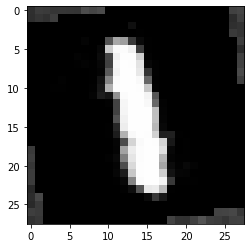

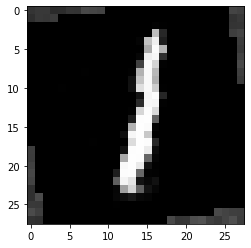

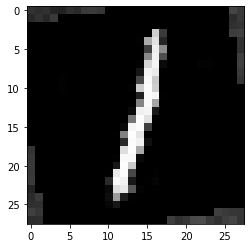

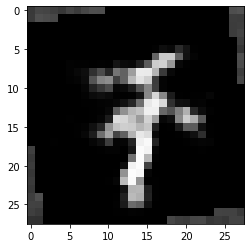

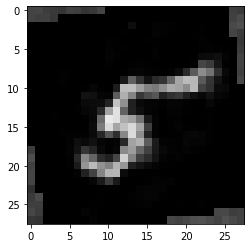

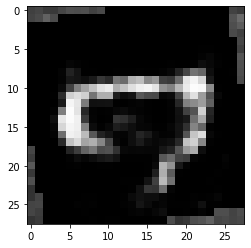

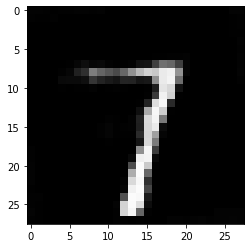

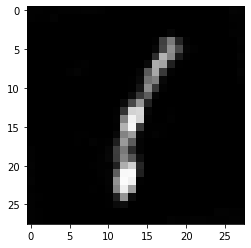

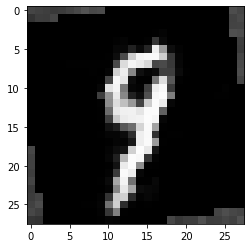

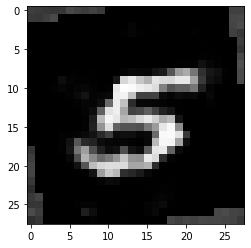

In [37]:
def show_image(img):
  npimg = img.detach().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

for i in range (0,10):
    show_image(torchvision.utils.make_grid(reconstructed_images[0][i].reshape(28,28)))

Removing the Decoder and introducing the Classifier layer to classify:

In [38]:
# Remove the decoder
autoencoder = autoencoder.encoder

# Add the classifier
classifier = Classifier(bottleneck=512)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [39]:
train_losses=[]
train_accu=[]

eval_losses=[]
eval_accu=[]

for epoch in range(no_of_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for img,labels in train_loader:

        #img = img.view(img.size(0), -1)
        img = img.float()
        img = autoencoder(img)

        img = img.view(img.size(0), -1)
        outputs = classifier(img)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()




    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)

    print("Epoch [{}/30], Train Loss: {:.4f} | Train Accuracy: {:.4f}".format(epoch+1, running_loss/len(train_loader), accu))
    


Epoch [1/30], Train Loss: 0.5733 | Train Accuracy: 82.2014
Epoch [2/30], Train Loss: 0.3174 | Train Accuracy: 90.5894
Epoch [3/30], Train Loss: 0.2688 | Train Accuracy: 91.8251
Epoch [4/30], Train Loss: 0.2425 | Train Accuracy: 92.5364
Epoch [5/30], Train Loss: 0.2298 | Train Accuracy: 93.0641
Epoch [6/30], Train Loss: 0.2164 | Train Accuracy: 93.2673
Epoch [7/30], Train Loss: 0.2097 | Train Accuracy: 93.5230
Epoch [8/30], Train Loss: 0.2038 | Train Accuracy: 93.8213
Epoch [9/30], Train Loss: 0.1995 | Train Accuracy: 93.8180
Epoch [10/30], Train Loss: 0.1937 | Train Accuracy: 94.0934
Epoch [11/30], Train Loss: 0.1894 | Train Accuracy: 94.2179
Epoch [12/30], Train Loss: 0.1860 | Train Accuracy: 94.2441
Epoch [13/30], Train Loss: 0.1853 | Train Accuracy: 94.0966
Epoch [14/30], Train Loss: 0.1808 | Train Accuracy: 94.3654
Epoch [15/30], Train Loss: 0.1764 | Train Accuracy: 94.4670
Epoch [16/30], Train Loss: 0.1760 | Train Accuracy: 94.4998
Epoch [17/30], Train Loss: 0.1742 | Train Accurac

In [40]:
y_true = []
y_pred = []
y_scores = []

def test(data_loader):
    autoencoder.eval()
    with torch.no_grad():

        running_loss = 0.0
        correct = 0
        total = 0

        for img,labels in data_loader:

            #img = img.view(img.size(0), -1)
            img = img.float()
            img = autoencoder(img)

            img = img.view(img.size(0), -1)
            outputs = classifier(img)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            y_scores.extend(F.softmax(output, dim=1).tolist())

        test_loss=running_loss/len(data_loader)
        accu=100.*correct/total

        eval_losses.append(test_loss)
        eval_accu.append(accu)

        print("Test Loss: {:.4f} | Test Accuracy: {:.4f}".format( running_loss/len(data_loader), accu))

In [41]:
test(test_loader)

Test Loss: 0.1466 | Test Accuracy: 95.5262


Plotting Train Accuracies and Losses:

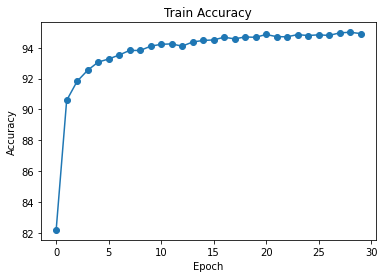

In [42]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Train Accuracy')

plt.show()

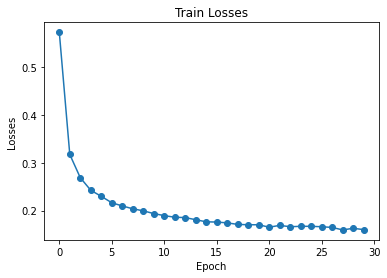

In [43]:
#plot losses

plt.plot(train_losses,'-o')


plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Train Losses')

plt.show()

In [44]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[1130    4    1    0    0]
 [   2  968   18   16    6]
 [   3   40  824   10   15]
 [  14   16    8  975   15]
 [  10   14   13   22  950]]


Confusion Matrix

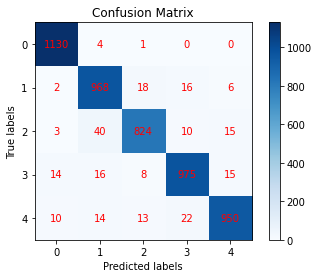

In [45]:
# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(np.arange(5))
plt.yticks(np.arange(5))
plt.title('Confusion Matrix')
plt.colorbar()

for i in range(5):
    for j in range(5):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.show()

Classification Report:

In [46]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1135
           1       0.93      0.96      0.94      1010
           2       0.95      0.92      0.94       892
           3       0.95      0.95      0.95      1028
           4       0.96      0.94      0.95      1009

    accuracy                           0.96      5074
   macro avg       0.95      0.95      0.95      5074
weighted avg       0.96      0.96      0.96      5074

